# Figure 1: Bathymetry, ANTOSTART, and Magnetics

This notebook produces figure 1 of Tankersley et al. 2022.
The figure display all of the input datasets used in our study.

In [5]:
# import necessary python packages
import pygmt
import pandas as pd
import geopandas as gpd
import os

In [6]:
# all file paths assume this notebook is in /RIS_basement_sediment/figures
pwd = os.getcwd()
pwd

'C:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_basement_sediment\\figures'

## Figure parameters

In [7]:
# set our PyGMT figure parameters, 
# we will use an Antarctic Polar Stereographic projection (EPSG3031)
# set the region of our figure, in meters from the South Pole
e= -760_000
n= -2_200_000
w= 600_000
s= -350_000

#set figure height, width and map scale
fig_height = 180 # in mm
fig_width = fig_height*(w-e)/(s-n)
fig_ratio = (s-n)/(fig_height/1000)

# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = f'{e}/{w}/{n}/{s}'
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

## Prep data

### Bedmachine

In [8]:
# prep BedMachine bathymetry
# add netCDF variable "geoid" to variable "bed" to get bed elevations relative to WGS84 ellipsoid
# save to new file -> BedMachine_bed_wgs.nc
!gmt grdmath ../data/input/BedMachineAntarctica_2020-07-15_v02.nc?bed ../data/input/BedMachineAntarctica_2020-07-15_v02.nc?geoid ADD = ../data/results/BedMachine_bed_wgs.nc
# resample this grid to 5km cells within our region of interest
pygmt.grdsample(grid='../data/results/BedMachine_bed_wgs.nc', 
                region='-3330000/1900000/-3330000/1850000',
                spacing='5000+e', registration='p',
                outgrid='../data/results/BedMachine_bed_5k_wgs.nc', verbose='e')

# repeat this for surface and icebase as they'll be needed for figure 4
# surface
# add geoid to make grid relative to WGS84 ellipsoid
!gmt grdmath ../data/input/BedMachineAntarctica_2020-07-15_v02.nc?surface ../data/input/BedMachineAntarctica_2020-07-15_v02.nc?geoid ADD = ../data/tmp/BedMachine_surface_wgs.nc
# resample this grid to 5km cells within our region of interest
pygmt.grdsample(grid='../data/tmp/BedMachine_surface_wgs.nc', 
                region='-3330000/1900000/-3330000/1850000',
                spacing='5000+e', registration='p',
                outgrid='../data/results/BedMachine_surface_5k_wgs.nc', verbose='e')

# icebase
# resample ice thickness grid to 5km cells within our region of interest
pygmt.grdsample(grid='../data/input/BedMachineAntarctica_2020-07-15_v02.nc?thickness', 
                region='-3330000/1900000/-3330000/1850000',
                spacing='5000+e', registration='p',
                outgrid='../data/tmp/BedMachine_thickness_5k.nc', verbose='e')
# subtract ice thickness from surface elevation to get ice base
!gmt grdmath ../data/results/BedMachine_surface_5k_wgs.nc ../data/tmp/BedMachine_thickness_5k.nc SUB = ../data/results/BedMachine_icebase_5k_wgs.nc

### ANTOSTRAT basement

In [9]:
# prep ANTOSTRAT basement (from Lindeque et al. sediment thickness)
# resample lindeque sed thickness to match bedmap spacing / region
pygmt.grdsample(grid='../data/input/sedthick_total_v2_5km_epsg3031.nc', 
                region='-3330000/1900000/-3330000/1850000',
                spacing='5000+e', registration='p',
                outgrid='../data/tmp/Lindeque_sedthick_total.nc', verbose='e')
# subtract sed thickness from bed to get basement
!gmt grdmath -Df ../data/results/BedMachine_bed_5k_wgs.nc ../data/tmp/Lindeque_sedthick_total.nc SUB = ../data/results/Lindeque_bedmachine_basement.nc
# in QGIS edited groundingline shp to stop at RIS calving front and Ross Island.
# use the shapefile to make a mask of all data onshore and below ice shelf
!gmt grdmask ../data/shapefiles/GroundingLine_Antarctica_v02_edited.shp -G../data/tmp/coastline_mask.nc -I5000+e -rp -R-3330000/1900000/-3330000/1850000 -N1/NaN/NaN
# mask out ice shelf and onshore data
!gmt grdmath -Df ../data/results/Lindeque_bedmachine_basement.nc ../data/tmp/coastline_mask.nc MUL = ../data/results/Lindeque_bedmachine_basement.nc
# filter with 20km Gaussian filter to remove bathymetry-induced variations
pygmt.grdfilter(grid='../data/results/Lindeque_bedmachine_basement.nc', 
                filter='g20000', nans='r', distance='0', 
                outgrid='../data/results/Lindeque_bedmachine_basement.nc')

### Magnetics

In [10]:
# prep OIB & ROSETTA magnetics data
# these csv are the outputs of the Werner deconvolution process, which was performed in Geosoft Oasis Montaj.
ROSETTA='../data/input/Geosoft_mag_data.csv.gz'
OIB='../data/input/Geosoft_Werner_output.csv.gz'

# load as pandas dataframes
df_rs = pd.read_csv(ROSETTA, index_col=None, compression='gzip')
df_oib = pd.read_csv(OIB, index_col=None, compression='gzip')

# drop unnecessary columns
df_oib.drop(df_oib.columns.difference(['x','y','Line','Mag_anom_draped_1000']),axis=1, inplace=True)

# drop unneccessary lines, and NaNs
df_oib_403=df_oib[df_oib.Line.isin(['L403.1', 'L403.3'])].copy()
df_oib_404=df_oib[df_oib.Line.isin(['L404.590', 'L404.650', 'L590', 'L650'])].copy()
df_rs.dropna(inplace=True)
df_oib_403.dropna(inplace=True)
df_oib_404.dropna(inplace=True)

# block median 
rosetta_mag_block=pygmt.blockmedian(data=df_rs[["x", "y", "Mag_anom_draped_1000"]], 
                                    T=0.9999, 
                                    spacing="1000+e", 
                                    region='-760000/600000/-2200000/-350000')

oib_mag_block=pygmt.blockmedian(data=df_oib_403[["x", "y", "Mag_anom_draped_1000"]], 
                                T=0.9999, 
                                spacing="1000+e", 
                                region='-760000/600000/-2200000/-350000')

# ROSETTA mag average is -1214 nT, so shift up by 1214 to center around 0
rosetta_mag_block['Mag_anom_draped_1000_shift']=rosetta_mag_block.Mag_anom_draped_1000-rosetta_mag_block.Mag_anom_draped_1000.mean()
# OIB mag average is 73 nT, so shift down by 73 to center around 0
oib_mag_block['Mag_anom_draped_1000_shift']=oib_mag_block.Mag_anom_draped_1000-oib_mag_block.Mag_anom_draped_1000.mean()

# join together
rs_oib_mag_block = pd.concat([rosetta_mag_block, oib_mag_block])

# make into grid with ROSETTA and OIB, with 1km cell size, interpolated 4 cells from datapoints
pygmt.surface(x= rs_oib_mag_block.x, y=rs_oib_mag_block.y,
              z=rs_oib_mag_block.Mag_anom_draped_1000_shift, 
              spacing='1000+e', region=fig_reg, M='4c',
              outgrid='../data/results/RS_OIB_mag.nc', verbose='e') 

# make into just ROSETTA grid, with 1km cell size, interpolated 8 cells from datapoints
pygmt.surface(x= rosetta_mag_block.x, y=rosetta_mag_block.y,
              z=rosetta_mag_block.Mag_anom_draped_1000_shift, 
              spacing='1000+e', region=fig_reg, M='10c',
              outgrid='../data/results/rosetta_mag.nc', verbose='e') 

## Color scales

In [11]:
# create colorscales
# bathymetry
pygmt.grd2cpt(grid = '../data/results/Bedmachine_bed_5k_wgs.nc', cmap = 'batlowW', 
              limit = '-900/-300', nlevels=7, 
              output = '../data/plotting/RE_bathymetry.cpt') 
# imagery
pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', 
              continuous = True, output = '../data/plotting/moa.cpt')
# basement
pygmt.makecpt(series = '-6500/0/500', cmap='batlowW',
              continuous=False, background=True, output='../data/plotting/ANTOSTRAT.cpt')
# magnetics
pygmt.makecpt(series = '-200/200', cmap = 'panoply',
              background='o', output = '../data/plotting/RIS_mag.cpt')

## Make figure

C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
gmtset [WARNING]: Representation of font type not recognized. Using default.
C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning

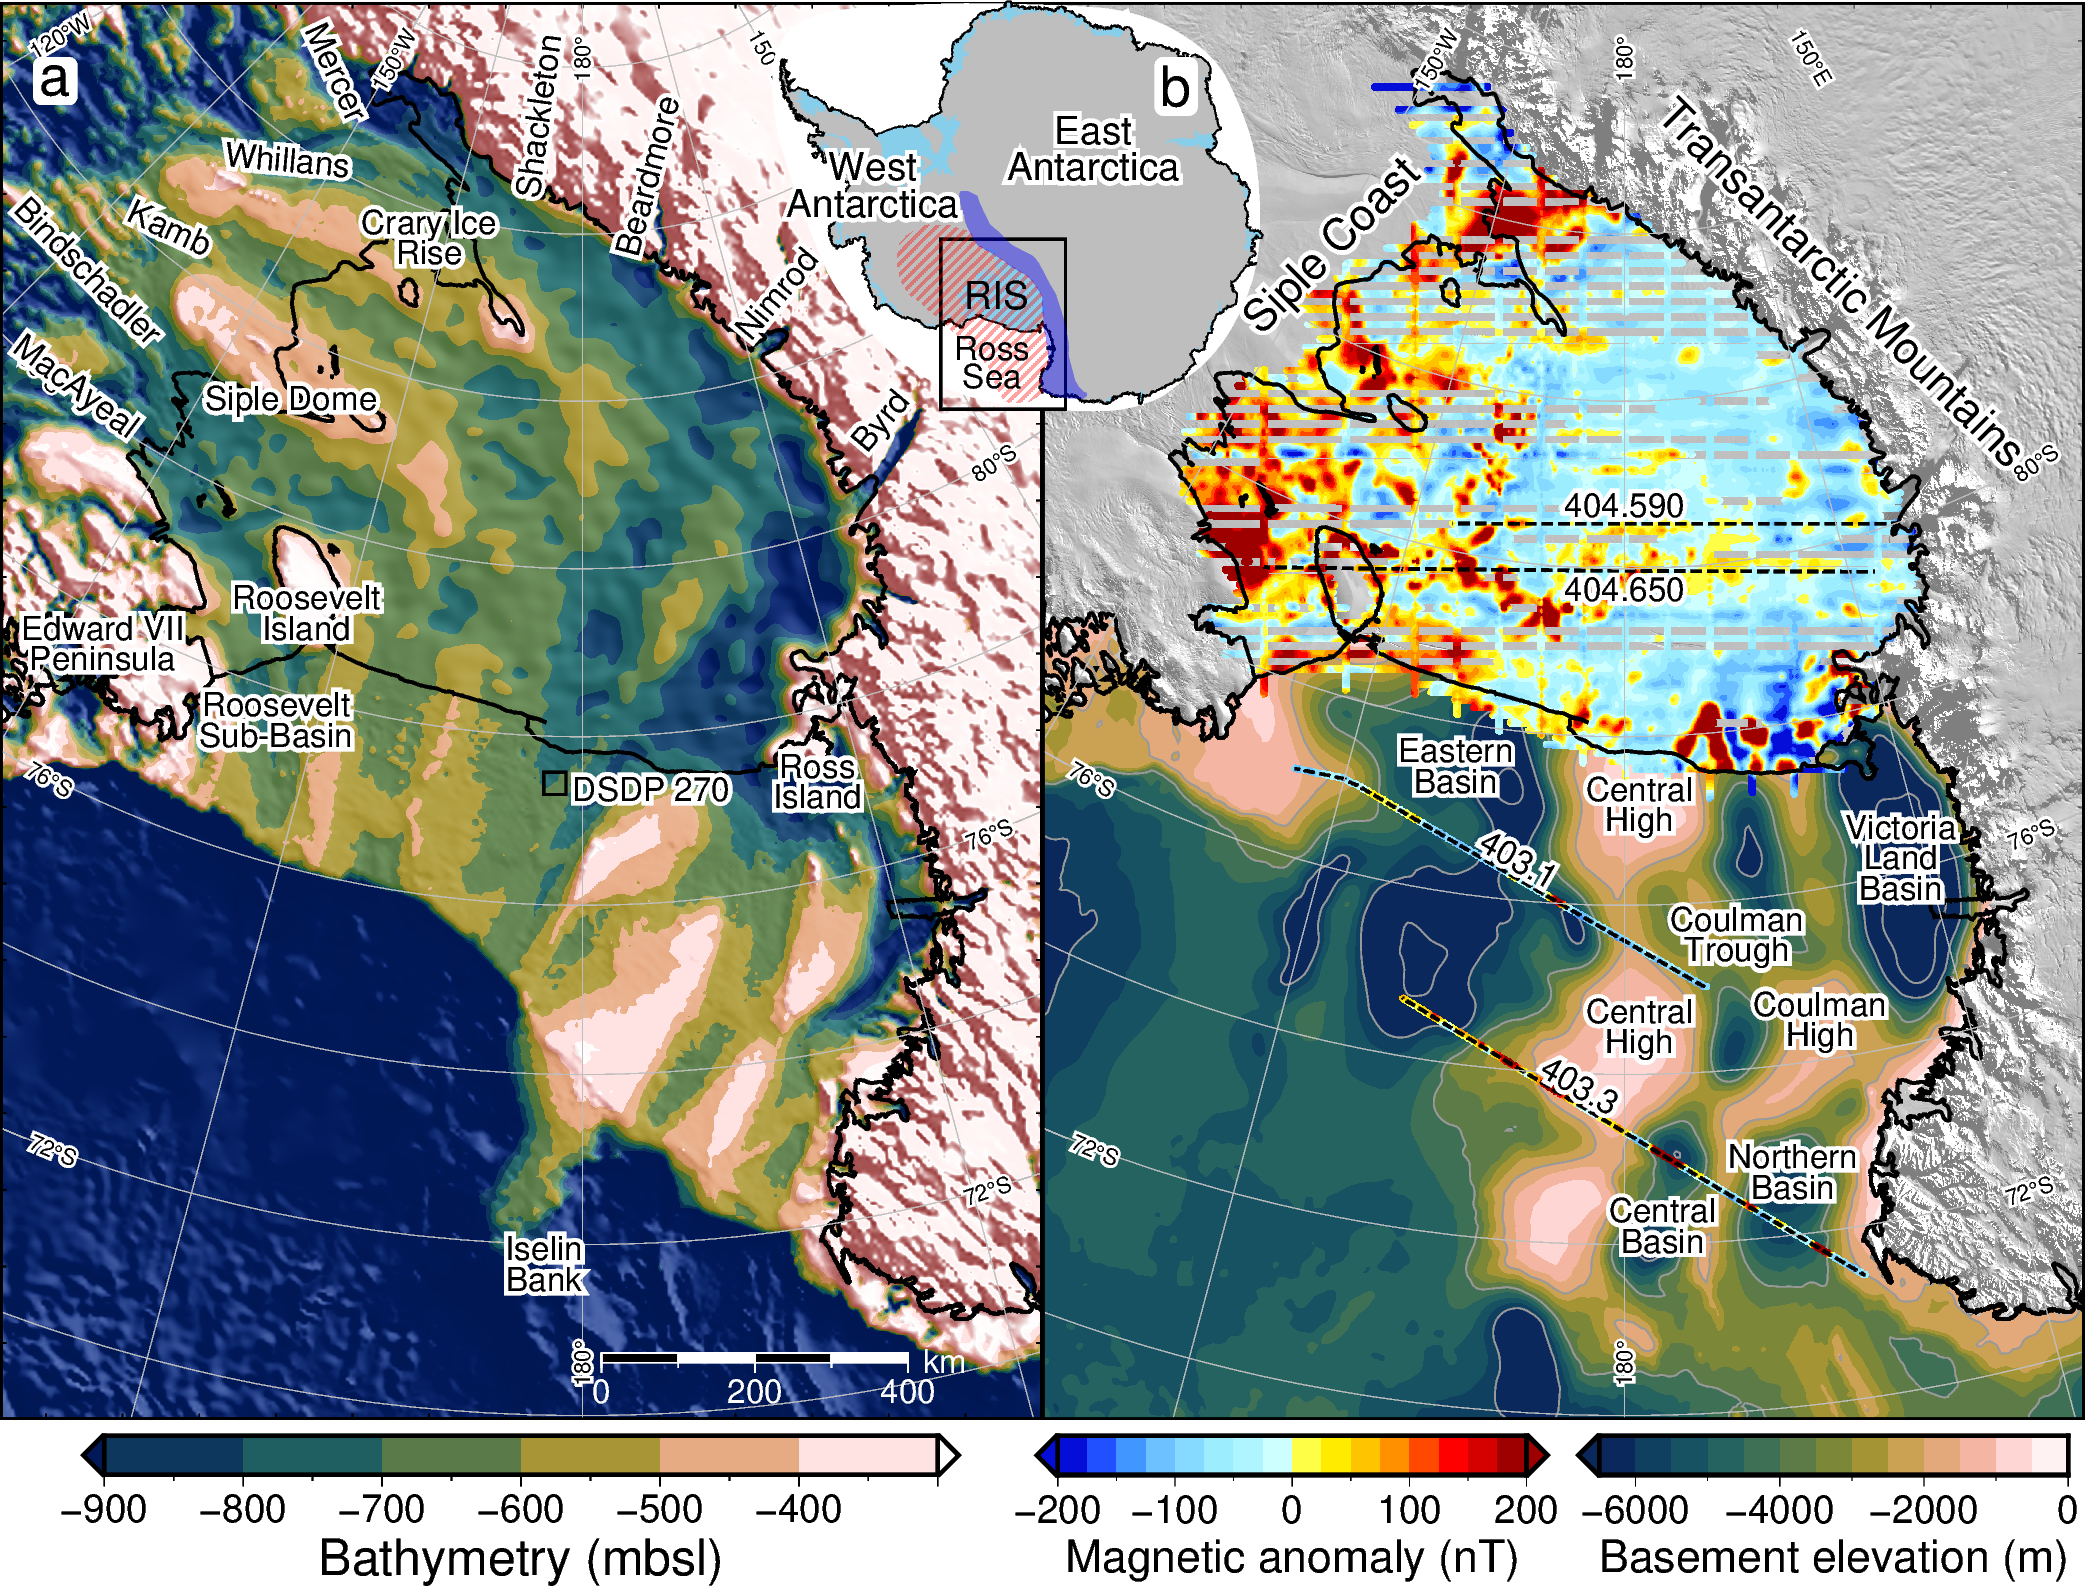

In [12]:
# initialize the figure
fig = pygmt.Figure()

# plot Bedmachine bathymetry as the basemap
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(projection=fig_proj,
             region=fig_reg,
             grid='../data/results/Bedmachine_bed_5k_wgs.nc',
             cmap='../data/plotting/RE_bathymetry.cpt',
             shading="grdgradient+a45+ne.5",
             dpi=500,
             frame = ["nwse", "xf100000", "yf100000", "g0"])

# add colorbar below figure
bar_width = fig_width/10 * 0.8 # color bar width is 80% of the map width, in cm
pos_str = f'jBC+w{bar_width}c/.5c+jTC+o0c/.2c+h+e'

with pygmt.config(FONT_ANNOT_PRIMARY = '14p,black', FONT_LABEL = '18p,black'):
    fig.colorbar(cmap='../data/plotting/RE_bathymetry.cpt', position = pos_str, 
                 frame=['xa100f50+l"Bathymetry (mbsl)"'], verbose='e')  

# plot groundingline and coastlines
fig.plot(data=gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')

# plot graticules overtop, at 4d latitude and 30d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black,-=2p,white', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
    fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
    with pygmt.config(FONT_ANNOT_PRIMARY = '8p,black'):
        fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30", "ya4"], verbose='e')

# plot square for DSDP 270 drill site
fig.plot(projection = fig_proj, x = -35781, y = -1369331, 
         pen = '1p,black', style = 's0.4c')

# plot location labels from .tsv file, with white shadow
fig.text(textfiles="../data/plotting/place_labels_Fig1a.tsv", angle=True, 
         font= '12,Helvetica,black,-=3p,white', justify=True,)
fig.text(textfiles="../data/plotting/place_labels_Fig1a.tsv", angle=True, 
         font= '12p,Helvetica,black', justify=True,) 
  
# plot scalebar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,white', FONT_LABEL = '12p,white',
                  MAP_SCALE_HEIGHT='7p', MAP_TICK_PEN_PRIMARY = '0.5p,white'):
    fig.basemap(projection = fig_proj_ll, 
                map_scale='jBR+w400k+c170E/71S+f+l"km"+ar+o1.7c/0.6c', verbose='e')

# plot figure label "a"
fig.text(projection = fig_proj, 
        region = fig_reg,
        position='TL',
        text = "a",
        fill = 'white',
        font = '20p,Helvetica,black',
        offset = 'j.5/.8',
        clearance = '+tO')

#################
#################
# shift origin to right, and start plot panel b
#################
#################

fig.shift_origin(xshift=fig_width/10)

# plot background as MODIS-MOA imagery, at 50% transparency
with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.grdimage(projection = fig_proj, region=fig_reg,
                 frame=["nwse", "xf100000", "yf100000", "g0"],
                 grid ='../data/input/moa750_2009_hp1_v1.1.tif', 
                 cmap = '../data/plotting/moa.cpt',transparency=50)

# plot ANTOSTRAT basement depths
fig.grdimage(grid='../data/results/Lindeque_bedmachine_basement.nc', 
             cmap='../data/plotting/ANTOSTRAT.cpt',
             nan_transparent=True, dpi='500')

# colorbar below figure
bar_width = fig_width/10 * 0.45 # color bar width is 40% of the map width, in cm
pos_str = f'jBR+w{bar_width}c/.5c+jTR+o.2c/.2c+h+eb'
with pygmt.config(FONT_ANNOT_PRIMARY = '14p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap='../data/plotting/ANTOSTRAT.cpt', position = pos_str, 
                 frame=['xa2000f1000+l"Basement elevation (m)"'], verbose='e')  

# plot 1km contours
fig.grdcontour(grid='../data/results/Lindeque_bedmachine_basement.nc', interval=2000, pen='thinner,grey60')
 
# plot OIB and ROSETTA magnetics
fig.grdimage(grid='../data/results/RS_OIB_mag.nc', cmap='../data/plotting/RIS_mag.cpt', nan_transparent=True)

# colorbar below figure
bar_width = fig_width/10 * 0.45 # color bar width is 40% of the map width, in cm
pos_str = f'jBL+w{bar_width}c/.5c+jTL+o.2c/.2c+h+e'
with pygmt.config(FONT_ANNOT_PRIMARY = '14p,black', FONT_LABEL = '16p,black'):
    fig.colorbar(cmap='../data/plotting/RIS_mag.cpt', position = pos_str, 
                 frame=['xa100f50+l"Magnetic anomaly (nT)"'], verbose='e')  

# plot flight paths of OIB 404
df_oib_404_590=df_oib_404[df_oib_404.Line.isin(['L404.590', 'L590'])].copy()
df_oib_404_590.dropna(how='any', inplace=True)
fig.plot(x=df_oib_404_590.x[df_oib_404_590.Line=='L590'], y=df_oib_404_590.y[df_oib_404_590.Line=='L590'], 
         pen='1.2p,black,4_2:2p')                    
fig.plot(x=df_oib_404.x[df_oib_404.Line=='L404.650'], y=df_oib_404.y[df_oib_404.Line=='L404.650'], 
         pen='1.2p,black,4_2:2p') 

# plot flight paths of OIB 403
fig.plot(x=df_oib_403.x[df_oib_403.Line=='L403.1'], y=df_oib_403.y[df_oib_403.Line=='L403.1'], 
         pen='1p,black,4_2:2p')                    
fig.plot(x=df_oib_403.x[df_oib_403.Line=='L403.3'], y=df_oib_403.y[df_oib_403.Line=='L403.3'], 
         pen='1p,black,4_2:2p') 

# plot groundingline and coastlines
fig.plot(data=gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')

# Plot graticules overtop, at 4d latitude and 30d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black,-=2p,white', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
    fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
    with pygmt.config(FONT_ANNOT_PRIMARY = '8p,black'):
        fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30", "ya4"], verbose='e')

# Add inset map to show location
# inset projection and region
inset_width = 7 # width of inset in cm
inset_reg = '-3000000/-3000000/3000000/3000000r'
inset_map = f'X{inset_width}c'

with fig.inset(position=f'JTL+jCM+w{inset_width}c+o-.4c/-2.6c'):
    # made this in QGIS to encompass Antarctica
    fig.plot(projection = inset_map, region = inset_reg, 
             data = gpd.read_file('../data/shapefiles/Antarctica_inset_outline.shp'),color = 'white')
    fig.plot(data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), color = 'skyblue')
    fig.plot(data = gpd.read_file('../data/shapefiles/GroundingLine_Antarctica_v02.shp'), color = 'grey')
    fig.plot(data = gpd.read_file('../data/shapefiles/Coastline_Antarctica_v02.shp'), pen='0.5p,black')
    fig.plot(x = [e, e, w, w, e], 
            y = [n, s, s, n, n], 
            pen = '1p,black')
    # WARS
    fig.plot(data = gpd.read_file('../data/shapefiles/WARS.shp'), color = "p9+bred+f-", transparency = 40)
    # TAM
    fig.plot( data = gpd.read_file('../data/shapefiles/TAM.shp'), color = "blue", transparency = 60)
    # Location labels
    fig.text(textfiles = "../data/plotting/place_labels_Fig1inset_shadow.tsv",
            angle = True, font = True, justify = True,)
    fig.text(textfiles = "../data/plotting/place_labels_Fig1inset.tsv",
            angle = True, font = True, justify = True,)        
        
# plot figure label "b"
fig.text(projection = fig_proj, 
        region = fig_reg,
        position='TL',
        text = "b",
        fill = 'white',
        font = '20p,Helvetica,black',
        offset = 'j1.5/.8',
        clearance = '+tO')

# Location labels
fig.text(textfiles="../data/plotting/place_labels_Fig1b.tsv", angle=True,
         font='12p,Helvetica,black,-=3p,white', justify=True)
fig.text(textfiles="../data/plotting/place_labels_Fig1b.tsv", angle=True,
         font='12p,Helvetica,black', justify=True)

fig.text(x=300000, y=-700000,
         text="Transantarctic Mountains",
         angle=-45, font='16p,Helvetica,black,-=3p,white', justify='TC')
fig.text(x=300000, y=-700000,
         text="Transantarctic Mountains",
         angle=-45, font='16p,Helvetica,black', justify='TC')

fig.text(x=-400000, y=-650000,
         text="Siple Coast",
         angle=45, font='16p,Helvetica,black,-=3p,white', justify='TC')
fig.text(x=-400000, y=-650000,
         text="Siple Coast",
         angle=45, font='16p,Helvetica,black', justify='TC')

fig.show(dpi=200)

## Save figure

In [13]:
out='outputs/Fig1_Bathy_Mag.jpg'
fig.savefig(out, dpi=200)

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.
